Data Mining -  Data Exploration

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Print the original sys.path
print('Original sys.path:', sys.path)

# Append a new directory to sys.path
sys.path.append('C:/Users/joepa/OneDrive/Desktop/computerScienceYear4/Data Mining/summary_eval/summary_eval')

# Print the updated sys.path
print('Updated sys.path:', sys.path)

# Now you should be able to import modules from the summary_eval package
from summary_eval.data import summary_df, prompts_df
from summary_eval.settings import TRAIN_SIZE
from summary_eval.testing import cross_validate

Original sys.path: ['C:\\Program Files\\JetBrains\\PyCharm 2023.3.4\\plugins\\python\\helpers-pro\\jupyter_debug', 'C:\\Program Files\\JetBrains\\PyCharm 2023.3.4\\plugins\\python\\helpers\\pydev', 'C:\\Users\\theaw\\summary-eval', 'C:\\Users\\theaw\\summary-eval\\notebooks', 'C:\\Users\\theaw\\summary-eval\\summary_eval', 'C:\\Users\\theaw\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'C:\\Users\\theaw\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'C:\\Users\\theaw\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'C:\\Users\\theaw\\AppData\\Local\\Programs\\Python\\Python310', 'C:\\Users\\theaw\\summary-eval\\venv', '', 'C:\\Users\\theaw\\summary-eval\\venv\\lib\\site-packages', 'C:\\Users\\theaw\\summary-eval\\venv\\lib\\site-packages\\win32', 'C:\\Users\\theaw\\summary-eval\\venv\\lib\\site-packages\\win32\\lib', 'C:\\Users\\theaw\\summary-eval\\venv\\lib\\site-packages\\Pythonwin', 'C:/Users/joepa/OneDrive/Desktop/computerScienceYear4/Data Mining/summary_e

Starting with analyzing distributions of content and wording scores. Goals:
-How strong is the relationship between the two?
-Do different prompts lead to different scores?
-...  

Correlation between content and wording scores: 0.7513804859701967


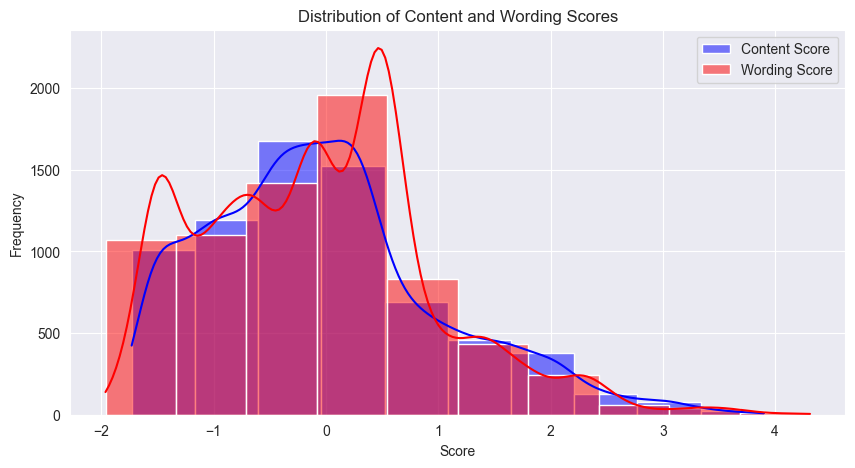

In [16]:

correlation = summary_df['content'].corr(summary_df['wording'])
print("Correlation between content and wording scores:", correlation)

plt.figure(figsize=(10, 5))
sns.histplot(data=summary_df, x='content', bins=10, kde=True, color='blue', label='Content Score')
sns.histplot(data=summary_df, x='wording', bins=10, kde=True, color='red', label='Wording Score')
plt.title('Distribution of Content and Wording Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

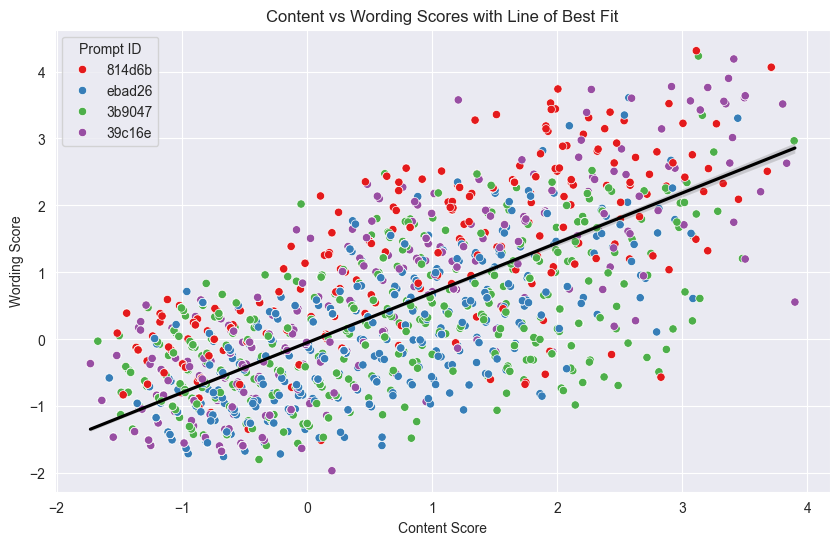

Summary Statistics for each Prompt ID:
            content             wording          
               mean       std      mean       std
prompt_id                                        
39c16e    -0.095457  0.969773 -0.140749  1.055695
3b9047     0.049579  1.106129 -0.068542  0.952708
814d6b     0.150306  1.124158  0.518733  1.107806
ebad26    -0.087906  0.990271 -0.299023  0.930270


In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=summary_df, x='content', y='wording', hue='prompt_id', palette='Set1')
sns.regplot(data=summary_df, x='content', y='wording', scatter=False, color='black')  
plt.title('Content vs Wording Scores with Line of Best Fit')
plt.xlabel('Content Score')
plt.ylabel('Wording Score')
plt.legend(title='Prompt ID')
plt.grid(True)
plt.show()

summary_stats = summary_df.groupby('prompt_id').agg({'content': ['mean', 'std'], 'wording': ['mean', 'std']})

print("Summary Statistics for each Prompt ID:")
print(summary_stats)

As shown above, 814d6b was answered best out of the 4.

In [18]:
def draw_scatter_plot(x_data, y_data, x_label, y_label, title, color):
    plt.figure(figsize=(8, 6))
    plt.scatter(x_data, y_data, color=color, alpha=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

Punctuation count:

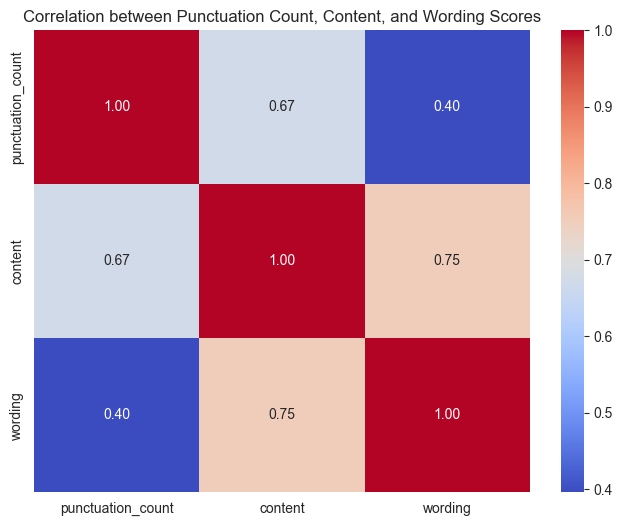

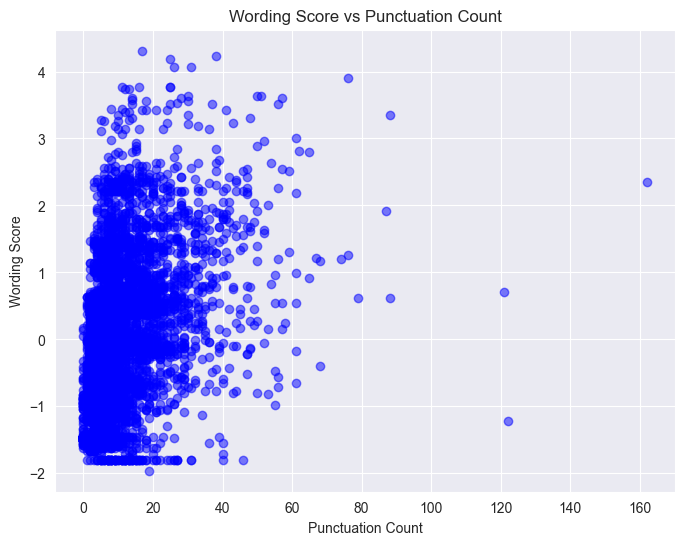

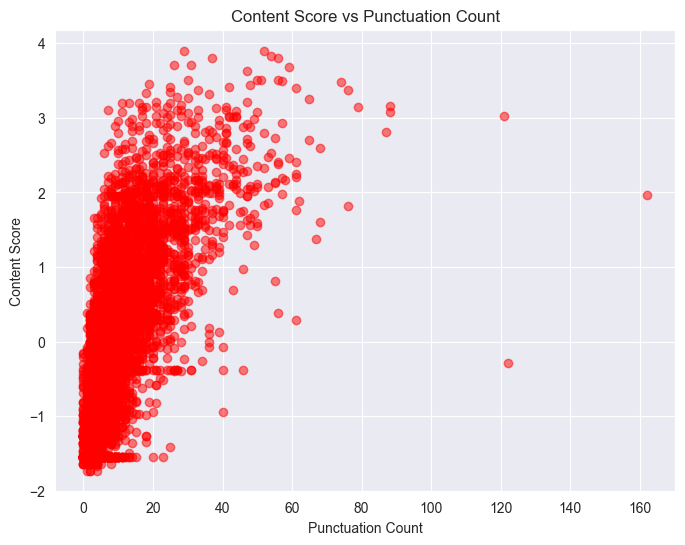

In [19]:
import string

def count_punctuation(text):
    return sum(1 for char in text if char in string.punctuation)

# Calculate punctuation count
summary_df['punctuation_count'] = summary_df['text'].apply(count_punctuation)

# Correlation calculation
correlation = summary_df[['punctuation_count', 'content', 'wording']].corr()

# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Punctuation Count, Content, and Wording Scores')
plt.show()

# Scatter plot of wording against punctuation count
draw_scatter_plot(summary_df['punctuation_count'], summary_df['wording'], 'Punctuation Count', 'Wording Score', 'Wording Score vs Punctuation Count', 'blue')

# Scatter plot of content against punctuation count
draw_scatter_plot(summary_df['punctuation_count'], summary_df['content'], 'Punctuation Count', 'Content Score', 'Content Score vs Punctuation Count', 'red')


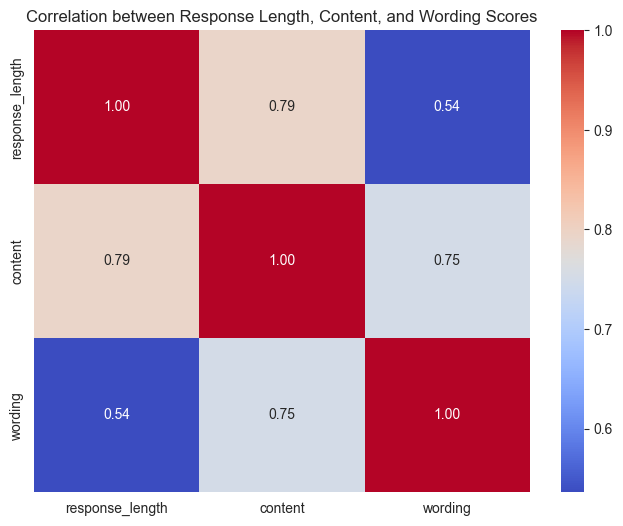

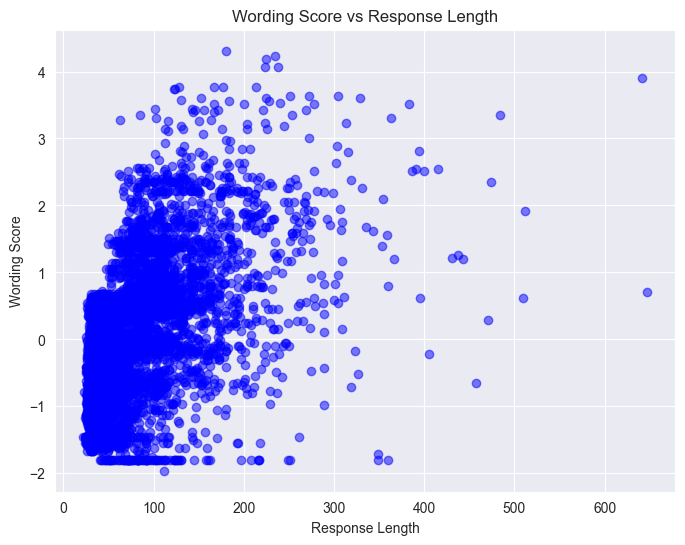

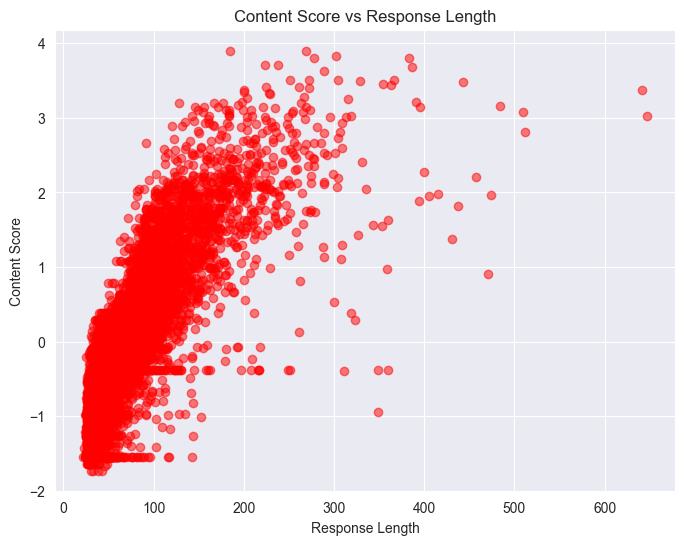

In [20]:
def count_words(text):
    return len(text.split())  # Split the text into words and return the number of words

# Calculate response length
summary_df['response_length'] = summary_df['text'].apply(count_words)

# Compute correlation between response length, content, and wording scores
correlation = summary_df[['response_length', 'content', 'wording']].corr()

# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Response Length, Content, and Wording Scores')
plt.show()

draw_scatter_plot(summary_df['response_length'], summary_df['wording'], 'Response Length', 'Wording Score', 'Wording Score vs Response Length', 'blue')

draw_scatter_plot(summary_df['response_length'], summary_df['content'], 'Response Length', 'Content Score', 'Content Score vs Response Length', 'red')


In [22]:
# import nltk
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theaw\AppData\Roaming\nltk_data...


True

In [23]:
from nltk.corpus import wordnet

def find_similar_words(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

def count_repeated_words(response, prompt):
    repeated_words = set()
    prompt_words = set(prompt.split())
    for word in response.split():
        if word in prompt_words:
            repeated_words.add(word)
        else:
            synonyms = find_similar_words(word)
            if synonyms.intersection(prompt_words):
                repeated_words.add(word)
    return len(repeated_words)

merged_df = pd.merge(summary_df, prompts_df, on='prompt_id')

# Calculate the number of repeated words for each response text
merged_df['repeated_words_prompt_text'] = merged_df.apply(lambda row: count_repeated_words(row['text'], row['prompt_text']), axis=1)

correlation = merged_df[['repeated_words_prompt_text', 'content', 'wording']].corr()
correlation_row = correlation.iloc[0]
print("Correlation between repeated words from prompt in user's response and scores:")
print(correlation_row)

merged_df['repeated_words_prompt_question'] = merged_df.apply(lambda row: count_repeated_words(row['text'], row['prompt_question']), axis=1)

correlation = merged_df[['repeated_words_prompt_question', 'content', 'wording']].corr()
correlation_row = correlation.iloc[0]
print("Correlation between repeated words from question in user's response and scores:")
print(correlation_row)

Correlation between repeated words from prompt in user's response and scores:
repeated_words_prompt_text    1.000000
content                       0.707474
wording                       0.375917
Name: repeated_words_prompt_text, dtype: float64
Correlation between repeated words from question in user's response and scores:
repeated_words_prompt_question    1.000000
content                           0.479256
wording                           0.386441
Name: repeated_words_prompt_question, dtype: float64


In [24]:
import textstat 
def calculate_readability(text):
    try:
        return textstat.flesch_kincaid_grade(text)  # try other readability scores from textstat
    except:
        return None

# Calculate readability score for each response
summary_df['readability_score'] = summary_df['text'].apply(calculate_readability)

# Drop NaN values from readability_score
summary_df = summary_df.dropna(subset=['readability_score'])

# Analyze the correlation between readability score and wording/content scores
correlation_readability = summary_df[['readability_score', 'content', 'wording']].corr()

print("Correlation between readability score and scores:")
print(correlation_readability)

Correlation between readability score and scores:
                   readability_score   content   wording
readability_score           1.000000 -0.038787 -0.131198
content                    -0.038787  1.000000  0.751380
wording                    -0.131198  0.751380  1.000000


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theaw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Correlation between stopwords count and scores:
                 stopwords_count   content   wording
stopwords_count         1.000000  0.778149  0.538102
content                 0.778149  1.000000  0.751380
wording                 0.538102  0.751380  1.000000


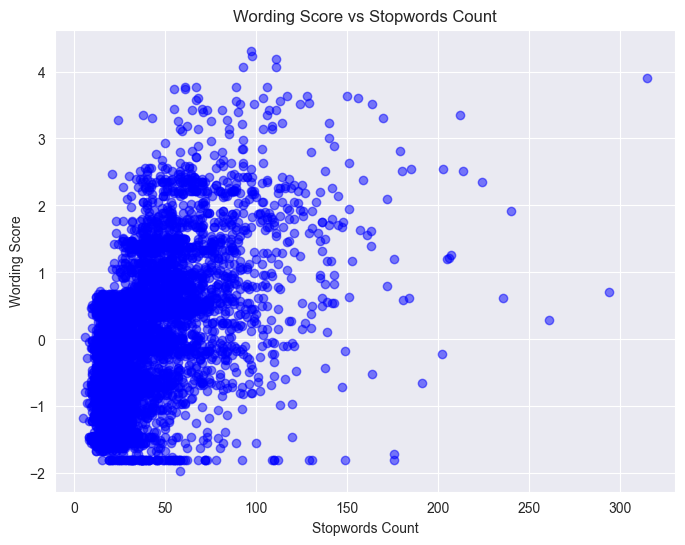

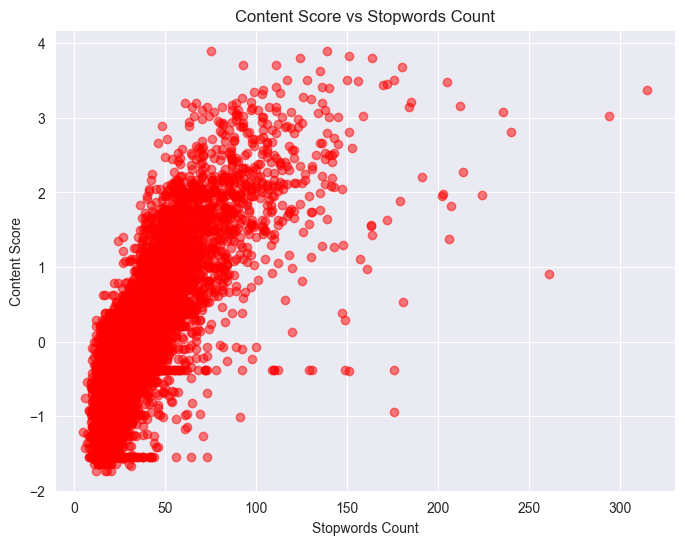

In [25]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to count the number of stopwords in a text
def count_stopwords(text):
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stop_words)
    return stopwords_count

# Calculate the number of stopwords for each response
summary_df['stopwords_count'] = summary_df['text'].apply(count_stopwords)

# Analyze the correlation between stopwords count and wording/content scores
correlation_stopwords = summary_df[['stopwords_count', 'content', 'wording']].corr()

print("Correlation between stopwords count and scores:")
print(correlation_stopwords)

plt.figure(figsize=(8, 6))
plt.scatter(summary_df['stopwords_count'], summary_df['wording'], color='blue', alpha=0.5)
plt.title('Wording Score vs Stopwords Count')
plt.xlabel('Stopwords Count')
plt.ylabel('Wording Score')
plt.grid(True)
plt.show()

# Scatter plot of stopwords count against content score
plt.figure(figsize=(8, 6))
plt.scatter(summary_df['stopwords_count'], summary_df['content'], color='red', alpha=0.5)
plt.title('Content Score vs Stopwords Count')
plt.xlabel('Stopwords Count')
plt.ylabel('Content Score')
plt.grid(True)
plt.show()

In [ ]:
#OTHER IDEAS
#Repitition
#Spelling- whilst shouldn't be taken into account
#Sentence Length
#Average Closeness to words in the prompt text
#Key word count - avg distance between key words
#word length mean and std deviation
#Types of punctuation - punctuation scores
#connective words

Correlation with Content Score: 0.7567871039131353
Correlation with Wording Score: 0.5205881185900668


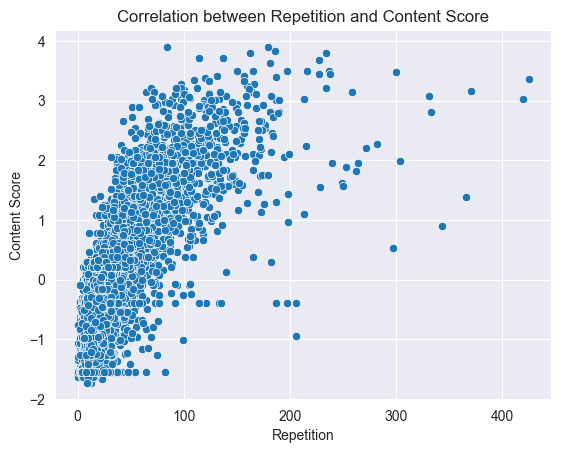

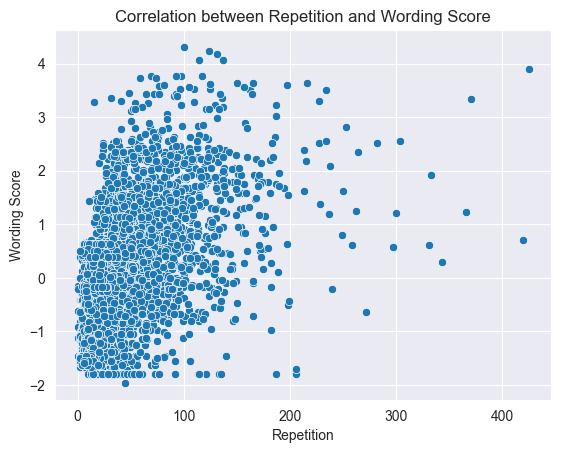

In [26]:
from collections import Counter
import numpy as np
def calculate_repetition(text):
    # Tokenize the text into words
    words = text.lower().split()
    # Count the frequency of each word
    word_counts = Counter(words)
    # Calculate repetition metric (e.g., total number of repeated words)
    repetition = sum(count for word, count in word_counts.items() if count > 1)
    return repetition

# Apply the repetition calculation to each row in the DataFrame
summary_df['repetition'] = summary_df['text'].apply(calculate_repetition)

# Compute the correlation between repetition and content/wording scores
correlation_content = np.corrcoef(summary_df['repetition'], summary_df['content'])[0, 1]
correlation_wording = np.corrcoef(summary_df['repetition'], summary_df['wording'])[0, 1]

print("Correlation with Content Score:", correlation_content)
print("Correlation with Wording Score:", correlation_wording)

# Visualize the correlation
sns.scatterplot(data=summary_df, x='repetition', y='content')
plt.title("Correlation between Repetition and Content Score")
plt.xlabel("Repetition")
plt.ylabel("Content Score")
plt.show()

sns.scatterplot(data=summary_df, x='repetition', y='wording')
plt.title("Correlation between Repetition and Wording Score")
plt.xlabel("Repetition")
plt.ylabel("Wording Score")
plt.show()

In [27]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Tokenize the prompt and response text
merged_df['prompt_tokens'] = merged_df['prompt_text'].apply(word_tokenize)
merged_df['response_tokens'] = merged_df['text'].apply(word_tokenize)

# Function to remove stop words from tokens
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

# Remove stop words from prompt tokens
merged_df['prompt_tokens'] = merged_df['prompt_tokens'].apply(remove_stopwords)

def calculate_avg_distance(prompt_tokens, response_tokens):
    key_words = set(prompt_tokens)  # Key words from prompt
    for word in prompt_tokens:
        key_words.update(find_similar_words(word))  # Add similar words to key words
    distances = []
    for key_word in key_words:
        min_distance = float('inf')
        for response_word in response_tokens:
            distance = nltk.edit_distance(key_word, response_word)
            if distance < min_distance:
                min_distance = distance
        distances.append(min_distance)
    return np.mean(distances)

# Apply the average distance calculation to each row in the DataFrame
merged_df['avg_key_word_distance'] = merged_df.apply(lambda row: calculate_avg_distance(row['prompt_tokens'], row['response_tokens']), axis=1)

# Compute the correlation between average distance and content/wording scores
correlation_content = np.corrcoef(merged_df['avg_key_word_distance'], merged_df['content'])[0, 1]
correlation_wording = np.corrcoef(merged_df['avg_key_word_distance'], merged_df['wording'])[0, 1]

print("Correlation with Content Score:", correlation_content)
print("Correlation with wording Score:", correlation_wording)

# Visualize the correlation
sns.scatterplot(data=merged_df, x='avg_key_word_distance', y='content')
plt.title("Correlation between Average Key Word Distance and Content Score")
plt.xlabel("Average Key Word Distance")
plt.ylabel("Content Score")
plt.show()

sns.scatterplot(data=merged_df, x='avg_key_word_distance', y='wording')
plt.title("Correlation between Average Key Word Distance and wording Score")
plt.xlabel("Average Key Word Distance")
plt.ylabel("wording Score")
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theaw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyboardInterrupt: 

In [ ]:
word_lengths = []
for text in summary_df['text']:
    words = word_tokenize(text)
    word_lengths.append([len(word) for word in words])

# Compute mean and standard deviation of word lengths for each text
mean_word_lengths = [np.mean(lengths) for lengths in word_lengths]
std_word_lengths = [np.std(lengths) for lengths in word_lengths]

# Compute correlation between mean and standard deviation of word lengths and content/readability scores
correlation_content_mean = np.corrcoef(mean_word_lengths, summary_df['content'])[0, 1]
correlation_wording_mean = np.corrcoef(mean_word_lengths, summary_df['wording'])[0, 1]

correlation_content_std = np.corrcoef(std_word_lengths, summary_df['content'])[0, 1]
correlation_wording_std = np.corrcoef(std_word_lengths, summary_df['wording'])[0, 1]

print("Correlation with Content Score (Mean Word Length):", correlation_content_mean)
print("Correlation with wording Score (Mean Word Length):", correlation_wording_mean)

print("Correlation with Content Score (Standard Deviation of Word Length):", correlation_content_std)
print("Correlation with wording Score (Standard Deviation of Word Length):", correlation_wording_std)

In [ ]:
# Function to count specific punctuation marks in text
def count_specific_punctuation(text):
    punctuation_counts = {'comma': text.count(','), 'quotation_mark': text.count('"'),
                          'bracket': text.count('(') + text.count(')'),
                          'full_stop': text.count('.')}
    return punctuation_counts

# Apply the function to each text in the DataFrame
summary_df['specific_punctuation_counts'] = summary_df['text'].apply(count_specific_punctuation)

# Compute correlation between specific punctuation counts and content/wording scores
correlations_content = {}
correlations_wording = {}
specific_punctuations = ['comma', 'quotation_mark', 'bracket', 'full_stop']
for punct in specific_punctuations:
    correlation_content = np.corrcoef(summary_df['specific_punctuation_counts'].apply(lambda x: x.get(punct, 0)), summary_df['content'])[0, 1]
    correlation_wording = np.corrcoef(summary_df['specific_punctuation_counts'].apply(lambda x: x.get(punct, 0)), summary_df['wording'])[0, 1]
    correlations_content[punct] = correlation_content
    correlations_wording[punct] = correlation_wording

# Display correlations
print("Correlation with Content Score:")
print(correlations_content)
print("\nCorrelation with wording Score:")
print(correlations_wording)

In [ ]:
connective_words = ['therefore', 'however', 'thus', 'consequently', 'moreover', 'furthermore', 'hence', 'nevertheless', 'therefore']

# Function to count connective words in text
def count_connective_words(text):
    connective_counts = {word: text.lower().count(word) for word in connective_words}
    return connective_counts

# Apply the function to each text in the DataFrame
summary_df['connective_counts'] = summary_df['text'].apply(count_connective_words)

# Compute correlation between connective word counts and content/wording scores
correlations_content = {}
correlations_wording = {}
for word in connective_words:
    correlation_content = np.corrcoef(summary_df['connective_counts'].apply(lambda x: x.get(word, 0)), summary_df['content'])[0, 1]
    correlation_wording = np.corrcoef(summary_df['connective_counts'].apply(lambda x: x.get(word, 0)), summary_df['wording'])[0, 1]
    correlations_content[word] = correlation_content
    correlations_wording[word] = correlation_wording

# Display correlations
print("Correlation with Content Score:")
print(correlations_content)
print("\nCorrelation with wording Score:")
print(correlations_wording)